# LSTM Neural Network
This script has the objective of converting output of the log filter (positions) into the machine learning model using keras.

In [1]:
# Essential imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# LSTM library
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
import keras

# File Management
import json

# Debug
from datetime import datetime
import time

2022-04-26 15:50:27.999668: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 15:50:27.999711: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First let's define the Hyper Parameters and global variables used on the algorithm.

In [7]:
N_CLOSEST_PLAYERS = 3

PAST_TIME_STEPS = 120 # Number of past steps that will be stored on the memory

# LABEL_COLUMN = 0 # Column on the object returned by the filtered log
# FEATURE_COLUMNS_RANGE = (0,0)

# TRAINING_PATH = "./training_model/csv_with_labels(full).csv"
TRAINING_PATH = "./training_model/dinis_game_1_labelled.csv"
TRAINING_START_ROW = 628 # default 0
TRAINING_END_ROW = 5000 # default -1

# TEST_PATH = "./training_model/csv_with_labels(full).csv"
TEST_PATH = "./training_model/dinis_game_1_labelled.csv"
TEST_START_ROW = 5000 # default 0
TEST_END_ROW = 7500 # default -1

# labels definition
# LABELS = ["Short Pass", "Long Pass", "Goal Shot"] 
# TODO: Complete with all labels
# OBS.: These labels will be in the matrix as index values (0..N-1),
# where N is the number of labels
N_NEURONS_LSTM = 10
BATCH_SIZE = 100
EPOCHS = 100

Here are some functions that will be used on the code. These functions don't have initial configuration because it'll depend how the log filter will be made.

In [8]:
def get_filtered_data(path="", starting_row=0, ending_row=-1):
    """Given a path to a csv file, returns the timestamp and the matrix """

    idxs = [i for i in range(0, N_CLOSEST_PLAYERS + 1)] + [i for i in range(12, N_CLOSEST_PLAYERS + 1)] + [23]

    training_csv = pd.read_csv(path, usecols=idxs).values
    timestamps = training_csv[starting_row:ending_row,0]
    matrix = training_csv[starting_row:ending_row, 1:]

    return timestamps, matrix


def vector_to_one_hot_encoding(vector):
    pass

Get the data and plot the graph

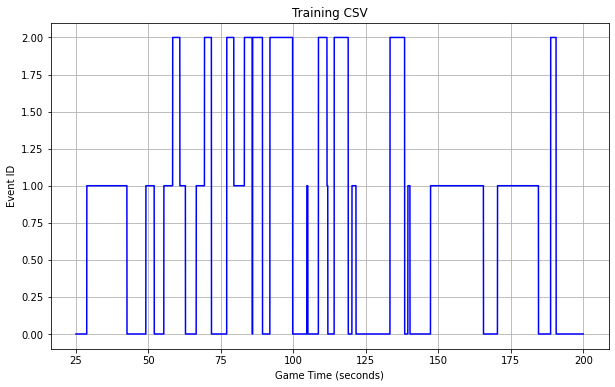

In [9]:
timestamps_training, positions_training = get_filtered_data(path=TRAINING_PATH, starting_row=TRAINING_START_ROW, ending_row=TRAINING_END_ROW)

plt.figure(figsize=(10,6))
plt.plot(timestamps_training, positions_training[:,-1] ,color='blue')
plt.title('Training CSV')
plt.xlabel('Game Time (seconds)')
plt.ylabel('Event ID')
plt.grid()
plt.show()


Now it's needed to get and proccess data accordingly

In [35]:
n_examples = len(positions_training)

n_features = positions_training.shape[1] - 1


# Applying normalization
scaler = MinMaxScaler(feature_range=(0,1)) # Apply values to [0, 1]
positions_training_scaled = scaler.fit_transform(positions_training)

# print(f"{positions_training = }")
# print(f"{positions_training_scaled = }")

# Convert training array to the right shape
features_set = []
labels = []

for i in range(PAST_TIME_STEPS, n_examples):
    features_set.append(positions_training_scaled[i-PAST_TIME_STEPS:i, 0:n_features]) # previous N records
    labels.append(positions_training_scaled[i, -1])

# Converting to numpy arrays
features_set, labels = np.array(features_set), np.array(labels)
# print(features_set)

# Converting to the LSTM format where the dimensions are:
# - number of records
# - number of time steps (past steps)
# - number of indicators/features.
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], features_set.shape[2]))
print(f"{features_set.shape = }")

features_set.shape = (4880, 120, 21)


Second Try

In [10]:
X_train = positions_training[:,:-1]
Y_train = positions_training[:,-1]
Y_train = Y_train.astype(np.int32)
unique, counts = np.unique(Y_train, return_counts=True)
print(unique, counts)

# Converts to array of ids itself (se calhar n precisa no futuro, usar enquanto aparecem poucos outputs nos labels)
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

Y_train = label_encoder.fit_transform(Y_train)

Y_train = Y_train.reshape(len(Y_train), 1)
Y_train_onehot = onehot_encoder.fit_transform(Y_train)
n_outputs = len(np.unique(Y_train))



print(Y_train_onehot)
print(n_outputs)


[0 1 2] [1890 1582  900]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
3


With the data loaded and formatted, now it's time to create the model itself.

In [38]:
# Model initialization
model = Sequential()

# Adding LSTM layer
# a funcao "add" literalmente adiciona um novo layer, que no nosso caso, sera um LSTM

# The fist LSTM parameter is the number of neurons on the node
# The second one is basically true, because we'll add more layers to the model
# The last one is a shape indicating the number of time steps and the number of indicators

model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True, input_shape=(features_set.shape[1], features_set.shape[2])))
# model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True))


# Adding Dropout layer (avoids over-fitting)
model.add(Dropout(0.2))

# Adding three more LSTM and Dropout layers
model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=False))
model.add(Dropout(0.2))

# model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=N_NEURONS_LSTM))
# model.add(Dropout(0.2))

# Adding Dense Layer (ending layer...?)
# 1 unit beause we want to predict
model.add(Dense(n_outputs, activation="softmax"))


# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])


Training the model

In [39]:
# Training the model
# epochs --> number of iteractions probably
history = model.fit(features_set, labels, epochs = EPOCHS, batch_size = BATCH_SIZE) # batch_size does a lot of improvement

Epoch 1/100


2022-04-24 20:08:12.426612: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 49190400 exceeds 10% of free system memory.


49/49 [==============================] - 20s 179ms/step - loss: 0.0986 - accuracy: 0.0652
Epoch 2/100
49/49 [==============================] - 11s 226ms/step - loss: 0.0986 - accuracy: 0.0559
Epoch 3/100
49/49 [==============================] - 12s 239ms/step - loss: 0.0986 - accuracy: 0.0668
Epoch 4/100
49/49 [==============================] - 11s 214ms/step - loss: 0.0986 - accuracy: 0.0725
Epoch 5/100
49/49 [==============================] - 7s 147ms/step - loss: 0.0986 - accuracy: 0.0662
Epoch 6/100
49/49 [==============================] - 7s 144ms/step - loss: 0.0986 - accuracy: 0.0770
Epoch 7/100
49/49 [==============================] - 8s 152ms/step - loss: 0.0986 - accuracy: 0.0689
Epoch 8/100
49/49 [==============================] - 11s 216ms/step - loss: 0.0986 - accuracy: 0.0686
Epoch 9/100
49/49 [==============================] - 8s 154ms/step - loss: 0.0986 - accuracy: 0.0770
Epoch 10/100
49/49 [==============================] - 6s 117ms/step - loss: 0.0986 - accuracy: 0.0

Plot History

dict_keys(['loss', 'accuracy'])


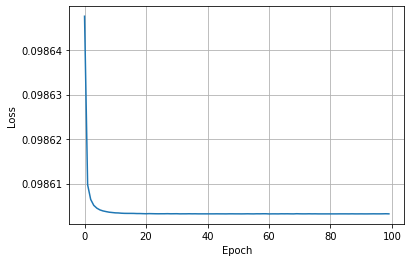

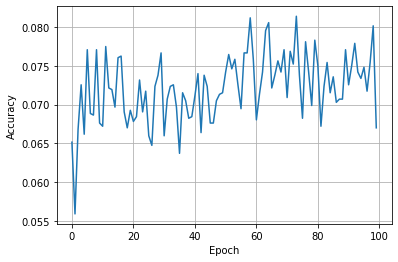

In [40]:
print(history.history.keys())
plt.plot(history.history.get("loss"))
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

plt.plot(history.history.get("accuracy"))
plt.grid()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

Plotting our test model

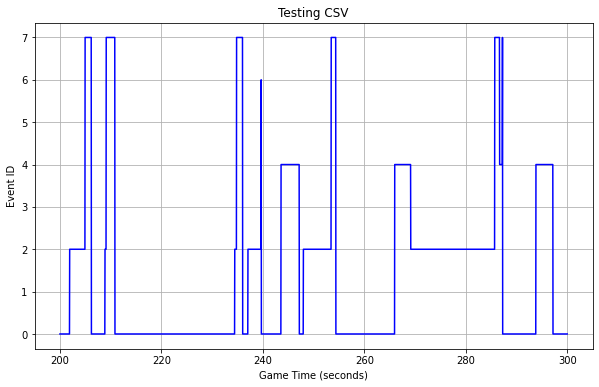

In [41]:
timestamps_testing, positions_testing = get_filtered_data(path=TEST_PATH, starting_row=TEST_START_ROW, ending_row=TEST_END_ROW)
plt.figure(figsize=(10,6))
plt.plot(timestamps_testing, positions_testing[:,-1] ,color='blue')
plt.title('Testing CSV')
plt.xlabel('Game Time (seconds)')
plt.ylabel('Event ID')
plt.grid()
plt.show()


Testing our model

In [42]:
# Reshaping the testing
positions_testing_scaled = scaler.transform(positions_testing)
n_tests = len(positions_testing)

# Add Past time
test_features = []
test_labels = []
for i in range(PAST_TIME_STEPS, n_tests): 
    test_features.append(positions_testing_scaled[i-PAST_TIME_STEPS:i, 0:n_features])
    test_labels.append(positions_testing_scaled[i, -1])


# Convert to the LSTM format
test_features = np.array(test_features)
test_labels = np.array(test_labels)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], test_features.shape[2]))

test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=2)
print(f"{test_loss = }")
print(f"{test_accuracy = }")

training_loss, training_accuracy = model.evaluate(features_set, labels, verbose=2)
print(f"{training_loss = }")
print(f"{training_accuracy = }")



2022-04-24 20:19:53.527448: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23990400 exceeds 10% of free system memory.


75/75 - 3s - loss: 0.0845 - accuracy: 0.0987 - 3s/epoch - 44ms/step
test_loss = 0.08454810082912445
test_accuracy = 0.09873949736356735


2022-04-24 20:19:57.175289: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 49190400 exceeds 10% of free system memory.


153/153 - 4s - loss: 0.0986 - accuracy: 0.0000e+00 - 4s/epoch - 23ms/step
training_loss = 0.09860336780548096
training_accuracy = 0.0


Making Predictions

In [43]:
predictions = model.predict(test_features)
print(f"{predictions.shape = }")
print(f"{predictions[0,:] = }") # probabilidade das 4 classes
print(f"{np.argmax(predictions[0:4])}")
# predictions_dataset_like = np.zeros(shape=(len(predictions), n_features))
# predictions_dataset_like[:,0] = predictions[:,0]
# # inverse transform and then select the right field
# predictions = scaler.inverse_transform(predictions_dataset_like)[:,0]

# predictions = scaler.inverse_transform(predictions[:,0]) # reverse the scale
# print(f"{predictions.shape = }")
# print(f"{test_features.shape = }")
# print(f"{n_features = }")



2022-04-24 20:20:27.228975: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23990400 exceeds 10% of free system memory.


predictions.shape = (2380, 7)
predictions[0,:] = array([0.14285904, 0.1428467 , 0.14286375, 0.14284642, 0.14284839,
       0.14288619, 0.1428495 ], dtype=float32)
26


Plot results

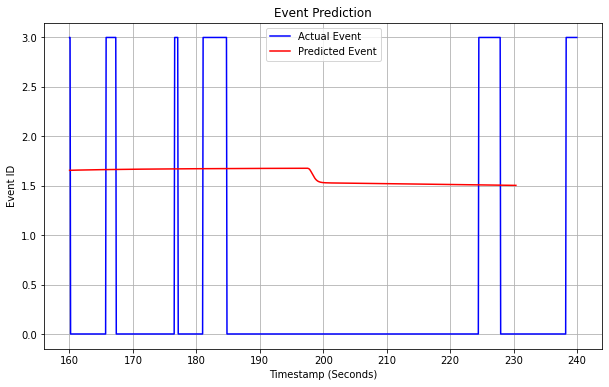

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(timestamps_testing, positions_testing[:,-1], color='blue', label='Actual Event')
plt.plot(timestamps_testing[:-PAST_TIME_STEPS], predictions[:,-1] , color='red', label='Predicted Event')
plt.title('Event Prediction')
plt.xlabel('Timestamp (Seconds)')
plt.ylabel('Event ID')
plt.legend()
plt.grid()
plt.show()